In [7]:
import torch
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from astropy.io import fits
from utils.fitsFun import *
from utils.Tools import get_mask
from utils.Tools import linear_scale
from utils.Tools import zscale_scale
from model.Generator import Generator

In [8]:
#Dataset---input fitspath
fitspath = r"./dataset/test/data.fits"
# fitspath = r"./dataset/train/1.fits"
img = fits.open(fitspath)[0].data
img = np.array(img, dtype=np.float32)
img = LoadSaveFits.norm(img)
img = torch.Tensor(img)
img = torch.unsqueeze(img, dim=0)


In [9]:
#Load model
G_AB = Generator(1, 1, 64)
checkpoint_path = './checkpoints/GWAC/model_latest.pth'
G_AB.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
img = torch.unsqueeze(img, dim=0)
out = G_AB(img)
img = torch.squeeze(img, dim=0)

In [10]:
# Set the size of the image and the size of the mask block
fineSize = 512
patch_size = 16
c, image_h, image_w = np.shape(img)
img = torch.unsqueeze(img, dim=0)
white = np.zeros((image_h, image_w), np.uint8)
num_y = image_h // fineSize
num_x = image_w // fineSize

In [11]:
# Generate mask
criterionMSE = nn.L1Loss()
loss_list = []
for x in range(num_x):
    for y in range(num_y):
        xy = img[:, :, fineSize * y:fineSize * (y + 1),fineSize * x:fineSize * (x + 1)]
        print(np.shape(xy))
        AB = G_AB(xy)
        errMSE = criterionMSE(AB, xy)
        datanumber = torch.Tensor.cpu(errMSE.data)
        datanumber = datanumber.data.numpy()
        loss_list.append(datanumber)
        mask, loss = get_mask(fineSize, fineSize, patch_size, patch_size, xy, AB)
        white[fineSize * y:fineSize * (y + 1), fineSize * x:fineSize * (x + 1)] = mask

torch.Size([1, 1, 512, 512])


(-0.5, 511.5, 511.5, -0.5)

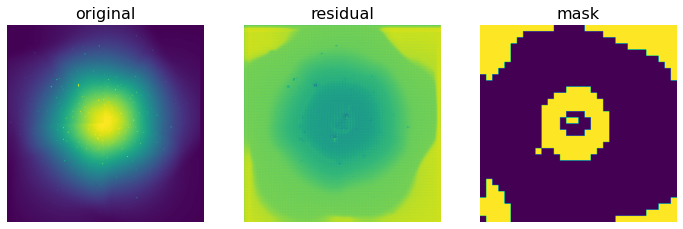

In [12]:
# Display result
plt.rcParams['figure.figsize'] = [12, 12]
plt.subplot(1, 3, 1)
img = np.array(img, dtype=np.float32)
img = linear_scale(img[0,0,:,:], 0, 255)
img = zscale_scale(img)
plt.imshow(img)
plt.title("original", fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(white)
plt.title("mask", fontsize=16)
plt.axis('off')

out = out.detach().numpy()
out = np.array(out, dtype=np.float32)
out = linear_scale(out[0,0,:,:], 0, 255)
out = zscale_scale(out)
plt.subplot(1, 3, 2)
plt.imshow(out-img)
plt.title("residual", fontsize=16)
plt.axis('off')
